In [1]:
# Import libraries
import warnings
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sqlalchemy import create_engine
import sqlite3

warnings.filterwarnings("ignore")

In [2]:
# Opens the JSON file containing watch history data and loads it into a DataFrame
with open("data/watch-history.json", encoding="utf-8") as f:
    watch_data = json.load(f)

df = pd.json_normalize(watch_data) # Normalize the JSON data into a flat table

print(df.columns)  # Print the columns of the DataFrame to understand its structure
# df.head() # Display the first few rows of the DataFrame for inspection

Index(['header', 'title', 'titleUrl', 'subtitles', 'time', 'products',
       'activityControls', 'details', 'description'],
      dtype='object')


In [3]:
# Modify the DataFrame to extract relevant information
df = df[df["header"] ==  "YouTube"] # Filter rows where header is "YouTube" (removes YouTube Music)
df = df[-df["title"].str.contains("Viewed")] # Exclude rows where title contains "Viewed" (removes interactions with YouTube posts)
df = df[df["subtitles"].notna()] # Filter out rows where subtitles are not available (channels cannot be identified without it)
df["title"] = df["title"].str.removeprefix("Watched ") # Remove "Watched " prefix from titles (so that titles are cleaner)
df["time"] = pd.to_datetime(df["time"], format='ISO8601', utc=True) # Convert time to datetime
df["time"] = df["time"].dt.tz_convert("Asia/Manila") # Convert timezone to Asia/Manila timezone
df["channel"] = df["subtitles"].apply(lambda x: x[0]['name']) # Extract channel name from subtitles

# Keep relevant columns
cleaned_df = df[['title', 'titleUrl', 'channel', 'time']]
# cleaned_df.head() # Display the first few rows of the cleaned DataFrame

In [4]:
# Display the top 10 YouTube channels based on the number of videos watched
top_channels = cleaned_df["channel"].value_counts().head(10) # Get the count of videos per channel and take the top 10
top_channels = top_channels.reset_index() # Reset index to convert Series to DataFrame
print("My Top 10 YouTube Channels:\n", top_channels)

My Top 10 YouTube Channels:
         channel  count
0           WWE   1509
1        CaseOh    814
2   GothamChess    740
3    MoreCaseOh    608
4     CVV CLIPS    584
5        PaoLUL    487
6  UpUpDownDown    316
7      camman18    268
8         PhiDX    235
9     PewDiePie    225


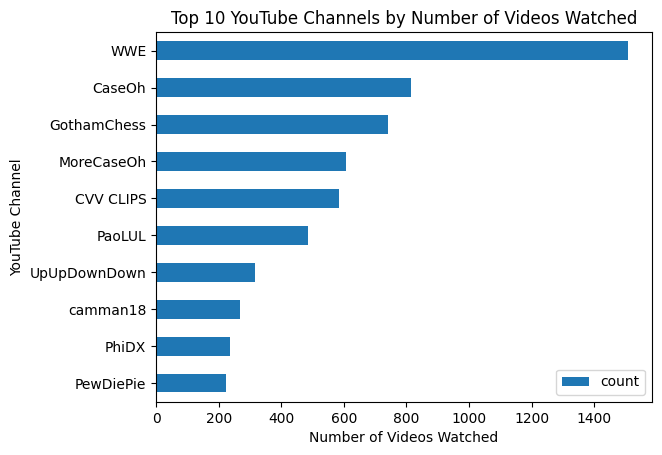

In [5]:
# Visualizes my Top 10 YouTube channels using Plotly Express
fig = px.bar(
    top_channels, # Sort the channels by number of videos watched
    x=top_channels["count"].sort_values(ascending=True), # Get the counts of videos watched
    y=top_channels["channel"].sort_index(ascending=False), # Get the channel names
    labels={'x': 'Number of Videos Watched', 'y': 'YouTube Channel'}, # Set axis labels
    title='Top 10 YouTube Channels by Number of Videos Watched', # Set the title of the chart
    orientation='h' # Set orientation to horizontal
)

fig.show() # Show the plot

# Or using Matplotlib
top_channels.sort_values(by='count', ascending=True).plot(
    kind='barh', x='channel', y='count', legend=True
) # Create a horizontal bar chart
plt.xlabel('Number of Videos Watched') # Set x-axis label 
plt.ylabel('YouTube Channel') # Set y-axis label
plt.title('Top 10 YouTube Channels by Number of Videos Watched') # Set the title of the chart
plt.show() # Show the plot

In [6]:
cleaned_df_copy = cleaned_df.copy() # Create a copy of the cleaned DataFrame to avoid modifying the original

In [7]:
channels_watched = pd.DataFrame(cleaned_df_copy["channel"].unique()) # Get unique channel names
channels_watched.columns = ["channels"] # Rename the column to "channels"
# channels_watched.head(10) # Display the first few rows of the DataFrame with unique channels

In [8]:
videos_watched = pd.DataFrame(cleaned_df_copy["title"].unique()) # Get unique video titles
videos_watched.columns = ["videos"] # Rename the column to "videos"
# videos_watched.head(10) # Display the first few rows of the DataFrame with unique videos

In [9]:
# Count the number of videos watched per month and prepare for visualization
cleaned_df_copy["month"] = cleaned_df_copy["time"].dt.month # Extract the month from the time column
monthly_counts = cleaned_df_copy['month'].value_counts().sort_index() # Count the number of videos watched per month and sort by month
monthly_df = monthly_counts.reset_index() # Reset index to convert Series to DataFrame
monthly_df.head() # Display the first few rows of the monthly DataFrame

,month,count
0,1,4972
1,2,2552
2,3,3364
3,4,4005
4,5,3542


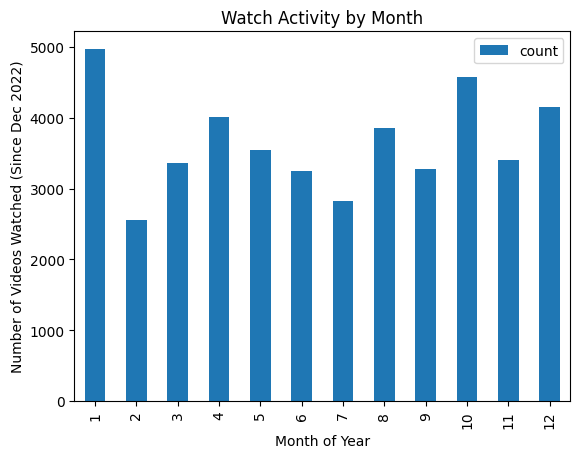

In [10]:
# Visualizes the watch activity by month using Plotly Express
fig = px.bar(
    monthly_df, # Use the monthly DataFrame for plotting
    x='month', # Use the month column for x-axis
    y='count', # Use the count of videos watched for y-axis
    title='Watch Activity by Month', # Set the title of the chart
    labels={'month': 'Month of Year', 'count': 'Number of Videos'}, # Set axis labels
    hover_data=['count'] # Show count in hover data
    )

fig.show() # Show the plot

# Or using Matplotlib
monthly_df.plot(
    kind='bar', x='month', y='count', legend=True
) # Create a horizontal bar chart
plt.xlabel('Month of Year') # Set x-axis label 
plt.ylabel('Number of Videos Watched (Since Dec 2022)') # Set y-axis label
plt.title('Watch Activity by Month') # Set the title of the chart
plt.show() # Show the plot

In [11]:
# Count the number of videos watched per hour and prepare for visualization
cleaned_df_copy["hour"] = cleaned_df_copy["time"].dt.hour # Extract the hour from the time column
hourly_counts = cleaned_df_copy['hour'].value_counts().sort_index() # Count the number of videos watched per hour and sort by hour
hourly_df = hourly_counts.reset_index() # Reset index to convert Series to DataFrame
hourly_df.head() # Display the first few rows of the hourly DataFrame

,hour,count
0,0,658
1,1,39
2,2,3
3,3,48
4,4,714


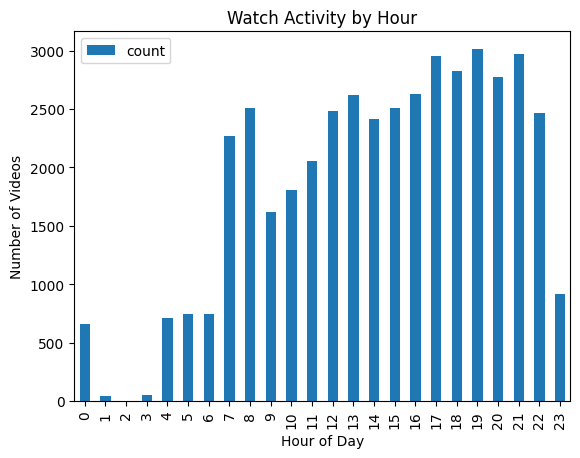

In [12]:
# Visualizes the watch activity by hour using Plotly Express
fig = px.bar(
    hourly_df, # Use the hourly DataFrame for plotting
    x='hour', # Use the hour column for x-axis
    y='count', # Use the count of videos watched for y-axis
    title='Watch Activity by Hour', # Set the title of the chart
    labels={'hour': 'Hour of Day', 'count': 'Number of Videos'}, # Set axis labels
    hover_data=['count'] # Show count in hover data
    )

fig.show()

# Or using Matplotlib
hourly_df.plot(
    kind='bar', x='hour', y='count', legend=True
) # Create a horizontal bar chart
plt.xlabel('Hour of Day') # Set x-axis label 
plt.ylabel('Number of Videos') # Set y-axis label
plt.title('Watch Activity by Hour') # Set the title of the chart
plt.show() # Show the plot

In [13]:
# Visualizes the watch history over time (monthly) using Plotly Express
cleaned_df_copy["year_month"] = cleaned_df_copy["time"].dt.to_period("M").astype(str) # Create a new column for year and month
monthly_counts = cleaned_df_copy["year_month"].value_counts().sort_index() # Count the number of videos watched per month and sort by month
monthly_df = monthly_counts.reset_index() # Reset index to convert Series to DataFrame
monthly_df.head() # Display the first few rows of the monthly DataFrame

,year_month,count
0,2022-12,348
1,2023-01,873
2,2023-02,355
3,2023-03,583
4,2023-04,485


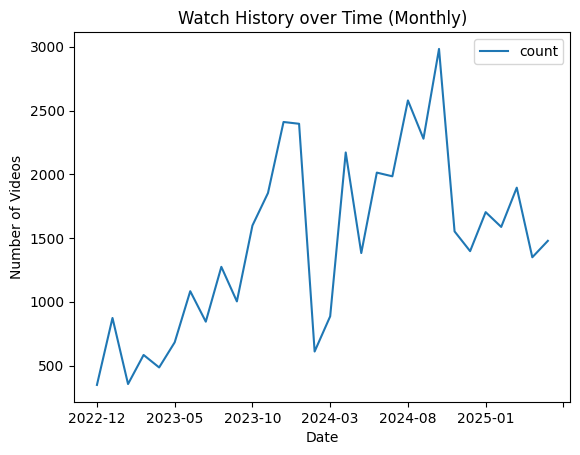

In [14]:
# Prepare the DataFrame for plotting
fig = px.line(
    monthly_df[:-1], # Exclude the last month since it is incomplete
    x="year_month", # Use the year_month column for x-axis
    y="count", # Use the count of videos watched for y-axis
    title="Watch History Over Time (Monthly)", # Set the title of the chart
    labels={"year_month": "Date", "count": "Number of Videos"}, # Set axis labels
    hover_data=["count"], # Show count in hover data
    markers=True # Add markers to the line plot
    )

fig.show() # Show the plot

# Or using Matplotlib
monthly_df[:-1].plot(
    kind='line', x='year_month', y='count', legend=True
) # Create a horizontal bar chart
plt.xlabel('Date') # Set x-axis label 
plt.ylabel('Number of Videos') # Set y-axis label
plt.title('Watch History over Time (Monthly)') # Set the title of the chart
plt.show() # Show the plot

In [15]:
# Count the number of videos watched per week and prepare for visualization
cleaned_df_copy["week"] = cleaned_df_copy["time"].dt.to_period("W").apply(lambda x: x.start_time) # Create a new column for weeks in string format
weekly_counts = cleaned_df_copy["week"].value_counts().sort_index() # Count the number of videos watched per week and sort by week
weekly_df = weekly_counts.reset_index() # Reset index to convert Series to DataFrame
weekly_df.head() # Display the first few rows of the weekly DataFrame

,week,count
0,2022-12-19,223
1,2022-12-26,163
2,2023-01-02,177
3,2023-01-09,142
4,2023-01-16,245


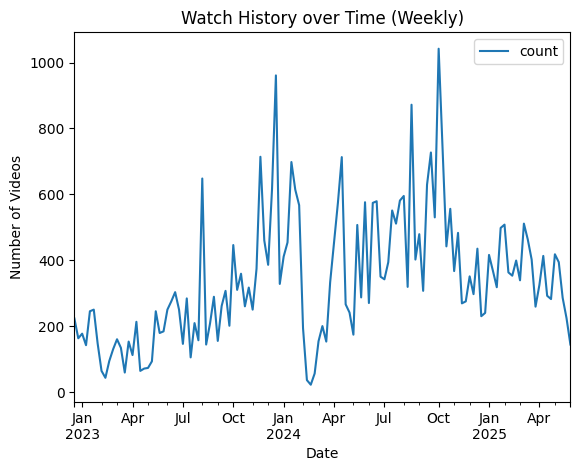

In [16]:
# Visualizes the watch history over time (monthly) using Plotly Express
fig = px.line(
    weekly_df[:-1], # Exclude the last week since it may be incomplete
    x="week", # Use the week column for x-axis
    y="count", # Use the count of videos watched for y-axis
    title="Watch History Over Time (Weekly)", # Set the title of the chart
    labels={"week": "Date", "count": "Number of Videos"}, # Set axis labels
    hover_data=["count"], # Show count in hover data
    markers=True # Add markers to the line chart
    )

fig.show() # Show the plot

# Or using Matplotlib
weekly_df[:-1].plot(
    kind='line', x='week', y='count', legend=True
) # Create a horizontal bar chart
plt.xlabel('Date') # Set x-axis label 
plt.ylabel('Number of Videos') # Set y-axis label
plt.title('Watch History over Time (Weekly)') # Set the title of the chart
plt.show() # Show the plot

In [17]:
engine = create_engine('sqlite:///data/watch_history.db') # Create a SQLite database engine
cleaned_df.to_sql('watch_history', con=engine, if_exists='replace', index=False) # Save the cleaned DataFrame to the database
channels_watched.to_sql('channels_watched', con=engine, if_exists='replace', index=False) # Save the channels watched to the database

13795

In [18]:
conn = sqlite3.connect('data/watch_history.db') # Connect to the SQLite database
cursor = conn.cursor() # Create a cursor object to execute SQL commands

cursor.execute('''
    SELECT * 
    FROM watch_history
    WHERE channel = "CaseOh"
    LIMIT 10;
''') # Execute a SQL command to select all data from the watch_history table
rows = cursor.fetchall() # Fetch all rows from the executed command
# for row in rows: # Iterate through each row
#     print(row) # Print each row to the console

conn.close() # Close the database connection